In [1]:
#change working dir to current file location

import os
import time
os.chdir('C:\\Users\\wren1\\Documents\\theory of machine learning\\EN625.742_group_project\\src')
from Code.Utils import utils
from Code.Charts import charts
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
#import TargetEncoder
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Feature Engineering

Steps:

1. Read in data
2. Clean data
3. Encode features
4. Feature selection

In [6]:
## Read in data 
print(os.getcwd())
full_df = pd.read_csv('data/sbdb_query_results.csv')
full_df.info(verbose=True, show_counts=True)

C:\Users\wren1\Documents\theory of machine learning\EN625.742_group_project\src
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35188 entries, 0 to 35187
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       35188 non-null  object 
 1   a               35188 non-null  float64
 2   e               35188 non-null  float64
 3   i               35188 non-null  float64
 4   om              35188 non-null  float64
 5   w               35188 non-null  float64
 6   q               35188 non-null  float64
 7   ad              35188 non-null  float64
 8   per_y           35188 non-null  float64
 9   data_arc        34876 non-null  float64
 10  condition_code  35187 non-null  float64
 11  n_obs_used      35188 non-null  int64  
 12  n_del_obs_used  1030 non-null   float64
 13  n_dop_obs_used  1030 non-null   float64
 14  H               35183 non-null  float64
 15  epoch_mjd       35188 non-null  int64  
 

C:\Users\wren1\AppData\Local\Temp\ipykernel_1004\3398585979.py:3: DtypeWarning: Columns (18,25,26,29,61) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('data/sbdb_query_results.csv')


In [16]:
# Clean data

# drop any colums with more than 20% missing values
df = utils.filterLowDataColumns(full_df, 0.2)

# drop any rows with missing values
df = df.dropna()

# df.info(verbose=True, show_counts=True)

# # drop any columns that are not useful for the model, like the producer of the record,
# the time of observation, and the standard error of existing columns
cols_to_drop = ['epoch_mjd', 
                'epoch', 
                'epoch_cal', 
                'first_obs', 
                'last_obs', 
                'producer',
                'sigma_e',
                'sigma_a',
                'sigma_q',
                'sigma_i',
                'sigma_om',
                'sigma_w',
                'sigma_ma',
                'sigma_ad',
                'sigma_n',
                'sigma_tp',
                'sigma_per',
                'rms',
                'full_name',
                'pdes',
                'condition_code',
                'tp_cal',
                'neo',
                'equinox',
                'sats']


df = df.drop(columns=cols_to_drop)

# drop spkid column - unique identifier
df = df.drop(columns=['spkid'])

# reset index to match the number of rows
df = df.reset_index(drop=True)

# separate target variable from features
target = df['pha']
features = df.drop(columns=['pha'])

#convert target from Y/N to 1/0

target = target.map({'Y': 1, 'N': 0})


# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Check for class imbalance
print(y_train.value_counts())

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# check if oversampling worked
print(y_train.value_counts())

# Scale numerical columns with RobustScaler (since many columns are not normally distributed)
num_cols = features.select_dtypes(include=['float64','int64']).columns

# Scale Numerical Columns with Robust Scaler
scaler = RobustScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Encode categorical variables
categorical_cols = features.select_dtypes(include=['object']).columns

# Fit and transform categorical columns
encoder = ce.cat_boost.CatBoostEncoder()

# create new columns for the encoded variables
encoded_col_names = [col + '_encoded' for col in categorical_cols]

X_train[encoded_col_names] = encoder.fit_transform(X_train[categorical_cols], y_train)
X_test[encoded_col_names] = encoder.transform(X_test[categorical_cols])

# remove major outliers with iqr

num_obs = X_train.shape[0]
print('number of observations before outlier removal:', num_obs)

from scipy import stats

def remove_outliers_zscore(df, threshold=3):
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return df[filtered_entries]

# Use the Z-score method with a threshold
X_train = remove_outliers_zscore(X_train.drop(columns=categorical_cols), threshold=3)
y_train = y_train[X_train.index]
X_test = remove_outliers_zscore(X_test.drop(columns=categorical_cols), threshold=3)
y_test = y_test[X_test.index]

#reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# number of outliers removed
num_outliers = num_obs - X_train.shape[0]
print(f'Number of outliers removed: {num_outliers}')
print('Number of observations after outlier removal:', X_train.shape[0])
# check if transformations and encoding worked
print(X_train.info())
print(X_train.head())


pha
0    25898
1     1979
Name: count, dtype: int64
pha
0    25898
1    25898
Name: count, dtype: int64
number of observations before outlier removal: 51796
Number of outliers removed: 5956
Number of observations after outlier removal: 45840
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45840 entries, 0 to 45839
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   a                 45840 non-null  float64
 1   e                 45840 non-null  float64
 2   i                 45840 non-null  float64
 3   om                45840 non-null  float64
 4   w                 45840 non-null  float64
 5   q                 45840 non-null  float64
 6   ad                45840 non-null  float64
 7   per_y             45840 non-null  float64
 8   data_arc          45840 non-null  float64
 9   n_obs_used        45840 non-null  float64
 10  H                 45840 non-null  float64
 11  ma                45840 non-null 

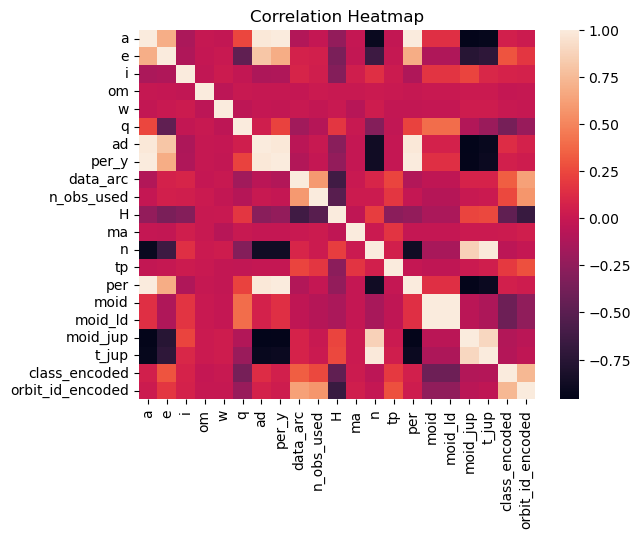

['ad', 'per_y', 'per', 'moid_ld', 'moid_jup', 't_jup']


In [17]:
# check for feature multicollinearity
# While tree methods are generally robust to multicollinearity, it is helpful to 
#  remove highly correlated features since they do not add any additional information
#  to the model and can impact feature importance scores
X_train_num = X_train.select_dtypes(include=['float64','int64'])

corr = X_train_num.corr()
sns.heatmap(corr, annot=False)
plt.title('Correlation Heatmap')
plt.show()

# drop highly correlated features
corr_matrix = X_train_num.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45840 entries, 0 to 45839
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   a                 45840 non-null  float64
 1   e                 45840 non-null  float64
 2   i                 45840 non-null  float64
 3   om                45840 non-null  float64
 4   w                 45840 non-null  float64
 5   q                 45840 non-null  float64
 6   data_arc          45840 non-null  float64
 7   n_obs_used        45840 non-null  float64
 8   H                 45840 non-null  float64
 9   ma                45840 non-null  float64
 10  n                 45840 non-null  float64
 11  tp                45840 non-null  float64
 12  moid              45840 non-null  float64
 13  class_encoded     45840 non-null  float64
 14  orbit_id_encoded  45840 non-null  float64
dtypes: float64(15)
memory usage: 5.2 MB


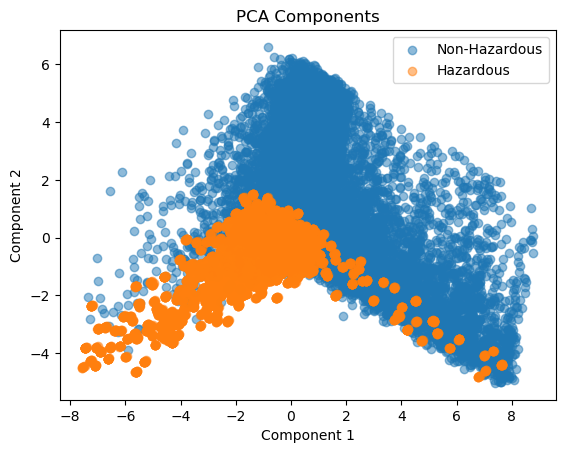

In [20]:
# we will use pca to get 2 components, so that we can visualize the data easily

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# plot the pca components

plt.scatter(X_train_pca[y_train==0][:,0], X_train_pca[y_train==0][:,1], label='Non-Hazardous', alpha=0.5)
plt.scatter(X_train_pca[y_train==1][:,0], X_train_pca[y_train==1][:,1], label='Hazardous', alpha=0.5)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Components')
plt.legend()
plt.show()



{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
0.9444154813609321
+--------------------+-------------------------+
|       Metric       |          Value          |
+--------------------+-------------------------+
|      Accuracy      |    0.8303059273422562   |
|      ROC AUC       |    0.8025076374745419   |
|      F1 Score      |   0.35727217863608934   |
| Mean Squared Error |   0.16969407265774378   |
|     Precision      | [0.98241055 0.2325216 ] |
|       Recall       | [0.83418194 0.77083333] |
|     R Squared      |   -1.9541910641547862   |
+--------------------+-------------------------+


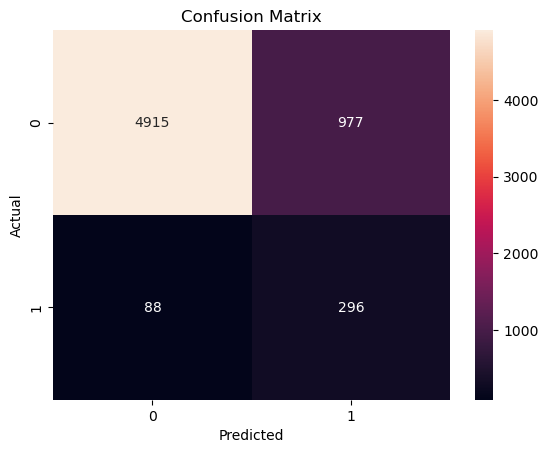

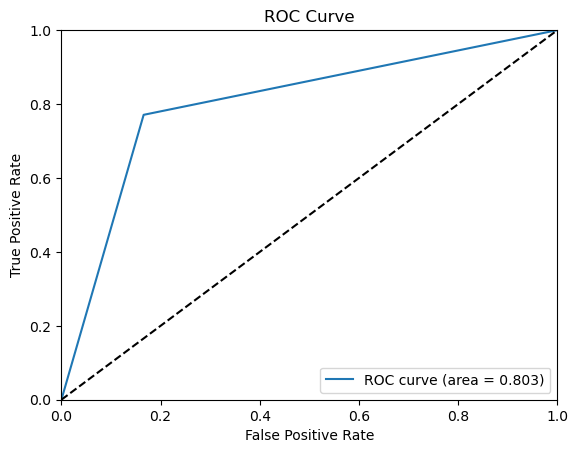

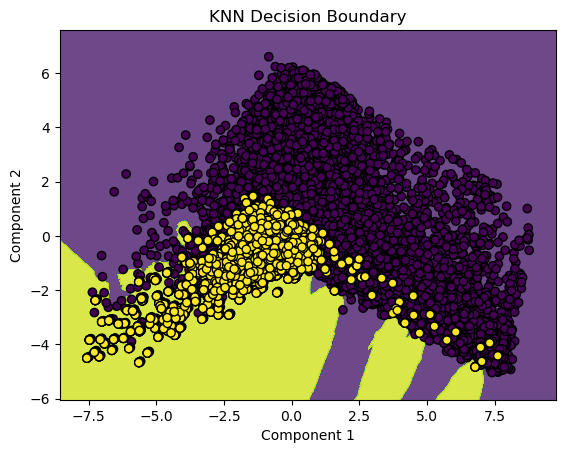

In [33]:
# fit knn model on pca components

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# grid search for best hyperparameters
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

#grid search with scoring on roc_auc
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_pca, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
# fit the model with best hyperparameters
knn = KNeighborsClassifier(**grid_search.best_params_)
knn.fit(X_train_pca, y_train)

# predict on test set
y_pred = knn.predict(X_test_pca)

#calculate recall and precision
recall = np.diag(confusion_matrix(y_test, y_pred)) / np.sum(confusion_matrix(y_test, y_pred), axis=1)
precision = np.diag(confusion_matrix(y_test, y_pred)) / np.sum(confusion_matrix(y_test, y_pred), axis=0)
# calculate R-squared
y_mean = np.mean(y_test)
sst = np.sum((y_test - y_mean) ** 2)
ssr = np.sum((y_test - y_pred) ** 2)
R_squared = 1 - (ssr / sst)


#print classification report in a pretty table
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Metric', 'Value']
table.add_row(['Accuracy', accuracy_score(y_test, y_pred)])
table.add_row(['ROC AUC', roc_auc_score(y_test, y_pred)])
table.add_row(['F1 Score', f1_score(y_test, y_pred)])
table.add_row(['Mean Squared Error', np.mean((y_test - y_pred)**2)])
table.add_row(['Precision',  precision])
table.add_row(['Recall', recall])
table.add_row(['R Squared', R_squared])

print(table)

#plot confusion matrix using seaborn 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# plot the decision boundary

from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

plot_decision_boundary(X_train_pca, y_train, knn, 'KNN Decision Boundary')

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
0.997821645689184
+--------------------+-------------------------+
|       Metric       |          Value          |
+--------------------+-------------------------+
|      Accuracy      |    0.8902166985340981   |
|      ROC AUC       |    0.9390964443312966   |
|      F1 Score      |    0.5258086717136957   |
| Mean Squared Error |   0.10978330146590184   |
|     Precision      | [0.9996159  0.35734331] |
|       Recall       | [0.88340122 0.99479167] |
|     R Squared      |   -0.9112090546503735   |
+--------------------+-------------------------+


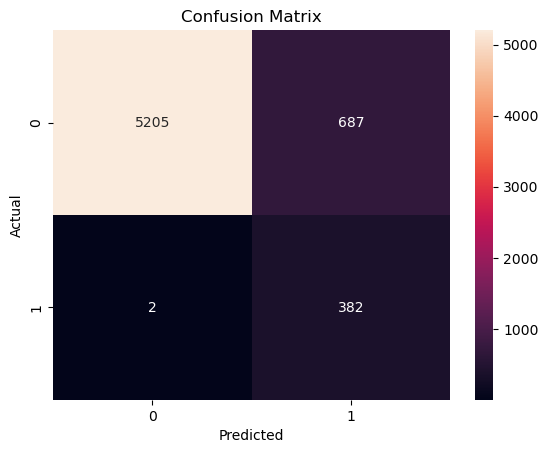

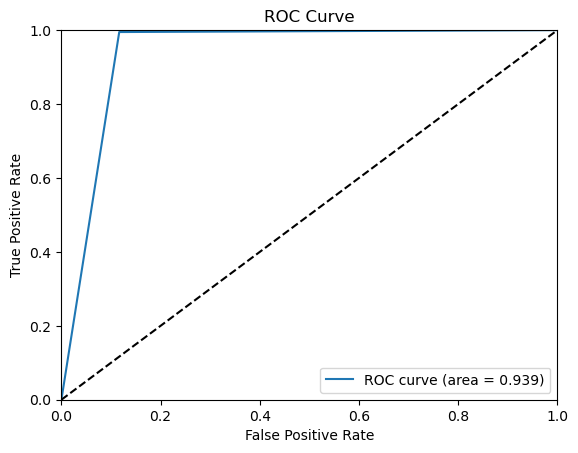

In [34]:
# now we will do KNN on the full component set, but we will not plot decision boundary
# since there are too many components
# grid search for best hyperparameters
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

#grid search with scoring on roc_auc
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

knn = KNeighborsClassifier(**grid_search.best_params_)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

#calculate recall and precision
recall = np.diag(confusion_matrix(y_test, y_pred)) / np.sum(confusion_matrix(y_test, y_pred), axis=1)
precision = np.diag(confusion_matrix(y_test, y_pred)) / np.sum(confusion_matrix(y_test, y_pred), axis=0)

# calculate R-squared
y_mean = np.mean(y_test)
sst = np.sum((y_test - y_mean) ** 2)
ssr = np.sum((y_test - y_pred) ** 2)
R_squared = 1 - (ssr / sst)

table = PrettyTable()
table.field_names = ['Metric', 'Value']
table.add_row(['Accuracy', accuracy_score(y_test, y_pred)])
table.add_row(['ROC AUC', roc_auc_score(y_test, y_pred)])
table.add_row(['F1 Score', f1_score(y_test, y_pred)])
table.add_row(['Mean Squared Error', np.mean((y_test - y_pred)**2)])
table.add_row(['Precision',  precision])
table.add_row(['Recall', recall])
table.add_row(['R Squared', R_squared])

print(table)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')

plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

